#### LIBRARIES USED

In [1]:
import numba
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from matplotlib import colors
from IPython import display
import time
from scipy.signal import convolve2d

#### SEGREGATION MODEL

The model describes the evolution of an population in a city, that is divided in Q blocks with H sites each. Each site can be occupied by 0 or 1 agent. The agents move around the city according to some rule, for example, maximize its utility.

#### FUNCTIONS'S DEFINITIONS

In [2]:
vacancy_value = 0
resident_value = 1
merchant_value = 2

In [3]:
def plot_grid(agents, n):
    # creates a discrete colormap
    vacancy = np.array([147.0/255, 148.0/255, 150.0/255])     # grey
    red = np.array([255.0/255, 0.0/255, 0.0/255])             # red
    cyan =  np.array([0.0/255, 200.0/255, 255.0/255])       # cyan
    cmap = colors.ListedColormap([vacancy, red, cyan])
    # determines the limits of each color:
    bounds = [vacancy_value, resident_value, merchant_value, merchant_value + 1]            
    norm = colors.BoundaryNorm(bounds, cmap.N)

    size = 8
    fig, ax = plt.subplots(figsize=(size,size))
    ax.imshow(agents, cmap=cmap, norm=norm)

    # draws gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, agents.shape[1], n));
    ax.set_yticks(np.arange(-0.5, agents.shape[0], n));

    plt.show()

In [4]:
def block_code(i,j):
    code = int(np.floor(j/n) + q * np.floor(i/n))
    return code

In [5]:
def create_city(n, q, agent_density, resident_relative_density):
    vacancy_array = np.array([[-1,-1,-1]])
    agent_array   = np.array([[-1,-1,-1, -1]])
    density_array = np.full(q*q,0.0)
    city_side = n*q
    
    # creates a city without borders, that will be a toroidal grid
    city = np.full((city_side,city_side), vacancy_value)
    residents = 0
    merchants = 0
    
    for code in range(q*q):
        block_x = int((code%q) * n)
        block_y = int(np.floor(code/q) * n)
        
        agents_in_block = 0.0
        
        for di in range(0,n):
            for dj in range(0,n):
                i = block_y + di
                j = block_x + dj
                rnd = np.random.random()
                if rnd <= agent_density:
                    rnd2 = np.random.random()
                    
                    if rnd2 <= resident_relative_density:
                        city[i,j] = resident_value
                        agents_in_block += 1
                        residents += 1
                        agent_array = np.append(agent_array, [[block_code(i,j), i, j, resident_value]], axis=0)
                    else:
                        city[i,j] = merchant_value
                        agents_in_block += 1
                        merchants += 1
                        agent_array = np.append(agent_array, [[block_code(i,j), i, j, merchant_value]], axis=0)
                else:
                     vacancy_array = np.append(vacancy_array, [[block_code(i,j), i, j]], axis=0)
        
        block_density = agents_in_block/(n*n)
        density_array[code] = block_density 

    vacancy_array = np.delete(vacancy_array, 0,0)
    agent_array = np.delete(agent_array, 0,0)
    
    return city, vacancy_array, agent_array, density_array, residents, merchants

In [27]:
def utility_function_resident(pho):
    m = 0.5
    if(pho <= 0.5):
        utility = 2*pho
    else:
        utility = 2*(m-1)*pho + 2 - m
    
    return utility

In [28]:
def utility_function_merchant(pho): 
    utility = pho
    return utility

In [29]:
def simulation_step(n, T, city, vacancy_array, agent_array, density_array):
    #we choose an agent and a vancant site in another block, it moves if its utility function increases.
    change = False
    rndV = np.random.randint(0, len(vacancy_array))
    rndA = np.random.randint(0, len(agent_array))
    codeV = vacancy_array[rndV,0] 
    codeA = agent_array[rndA,0]
    phoV = density_array[codeV]
    phoA = density_array[codeA]
    
    iV, jV = vacancy_array[rndV,1:3]
    iA, jA = agent_array[rndA,1:3]
    
    #merchant movement condition
    if(agent_array[rndA,3] == merchant_value):
        agent_utility = utility_function_merchant(phoA)
        new_agent_utility = utility_function_merchant(phoV + 1/(n*n))
        
        gain = new_agent_utility - agent_utility
        
        if T:
            prob = 1/(1 + np.exp(-gain/T))
        else:
            if gain >= 0:
                prob = 1
            else:
                prob = 0
            
        rnd = np.random.random()
        
        if(rnd < prob):
            change = True
    
    #resident movement condition
    elif(agent_array[rndA,3] == resident_value):
        agent_utility = utility_function_resident(phoA)
        new_agent_utility = utility_function_resident(phoV + 1/(n*n))
        
        gain = new_agent_utility - agent_utility
        
        prob = 1/(1 + np.exp(-gain/T))
        rnd = np.random.random()
        
        if(rnd < prob):
            change = True
    
    
    if(change):
        #update system
        
        #update vacancy and agent arrays
        vacancy_array[rndV] = [codeA,iA,jA]
        agent_array[rndA,0:3] = [codeV,iV,jV]

        #update city grid
        city[iA,jA] = vacancy_value
        city[iV,jV] = agent_array[rndA,3]
        
        #update density array
        density_array[codeV] += 1/(n*n)
        density_array[codeA] -= 1/(n*n)
    
    return city, vacancy_array, agent_array, density_array

#### MODEL TESTING

#### T = 0

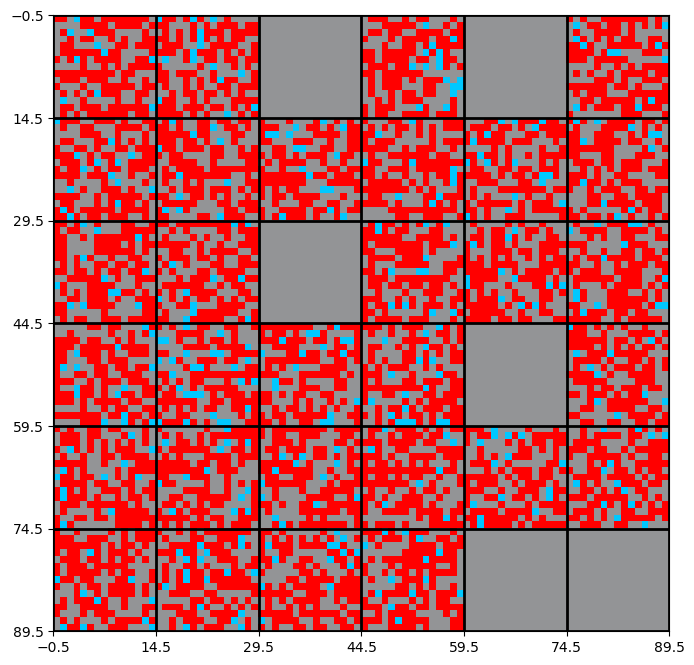

In [31]:
n = 15
q = 6
Ti = 0.2
Tf = 0
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

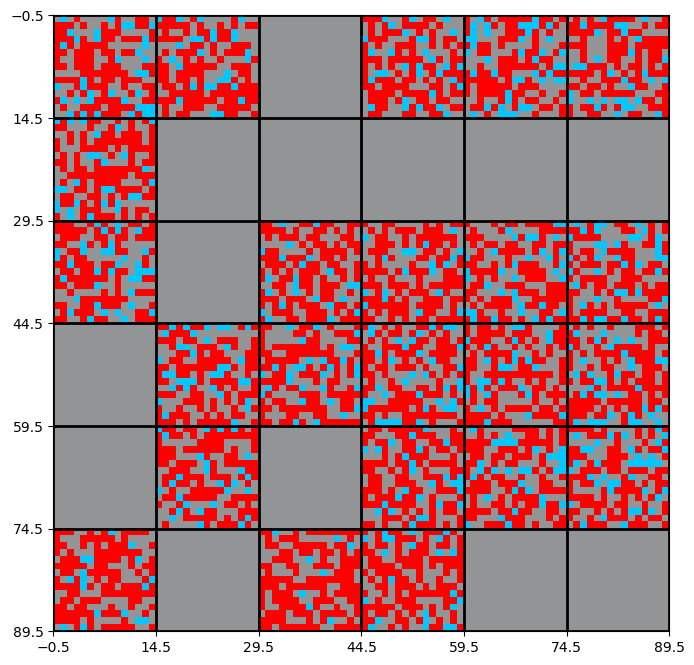

In [32]:
n = 15
q = 6
Ti = 0.2
Tf = 0
agent_density = 0.4
resident_relative_density = 0.8

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

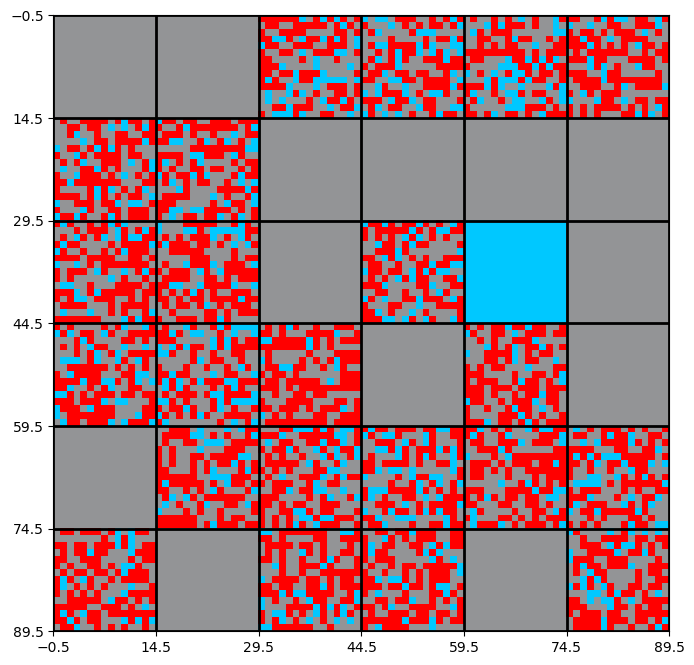

In [34]:
n = 15
q = 6
Ti = 0.2
Tf = 0
agent_density = 0.4
resident_relative_density = 0.7

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 10000000
passo = steps/5
freezing_time = 1/10
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

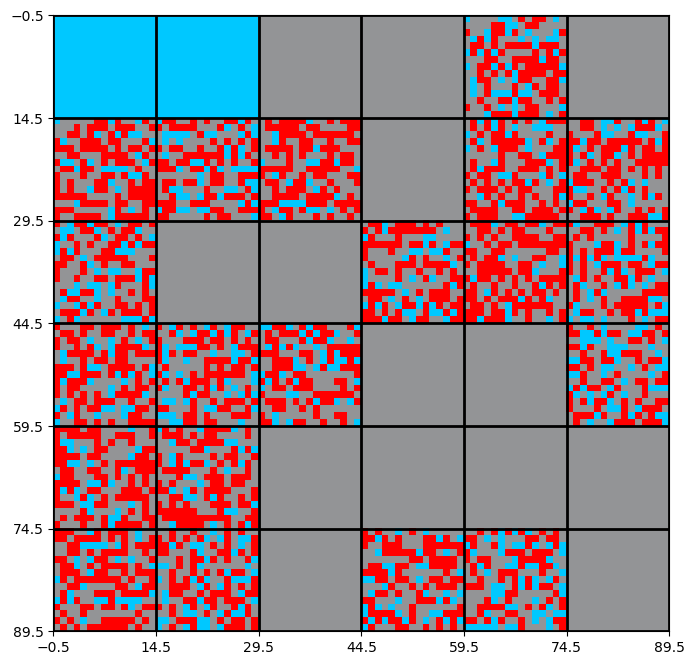

In [18]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.4
resident_relative_density = 0.6

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

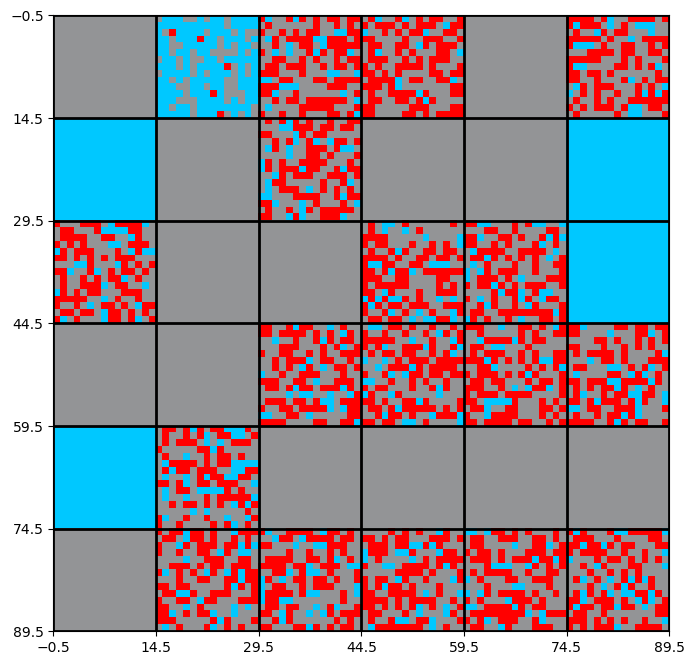

In [19]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.4
resident_relative_density = 0.5

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

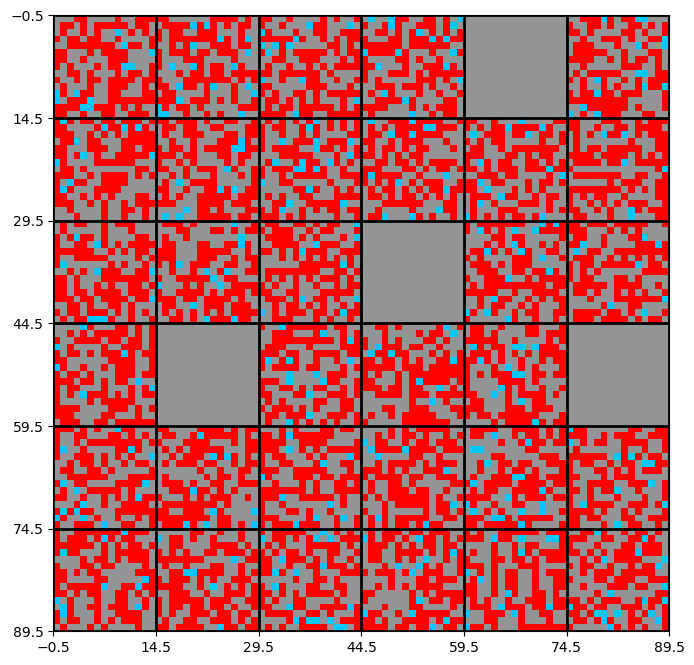

In [20]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.5
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

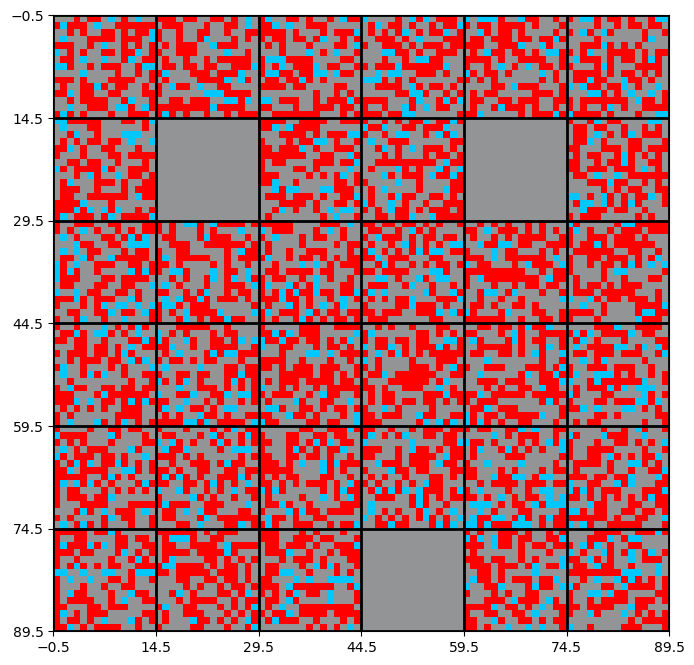

In [21]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.5
resident_relative_density = 0.8

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

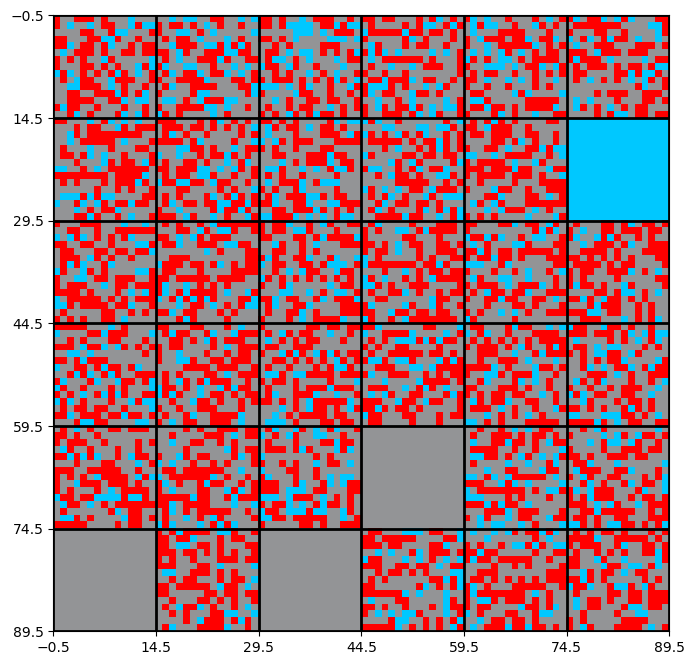

In [22]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.5
resident_relative_density = 0.7

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

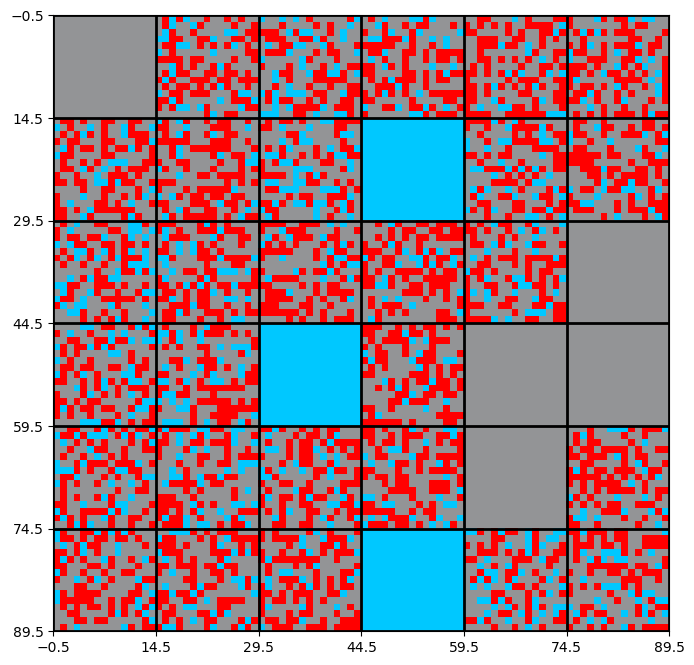

In [23]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.5
resident_relative_density = 0.6

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

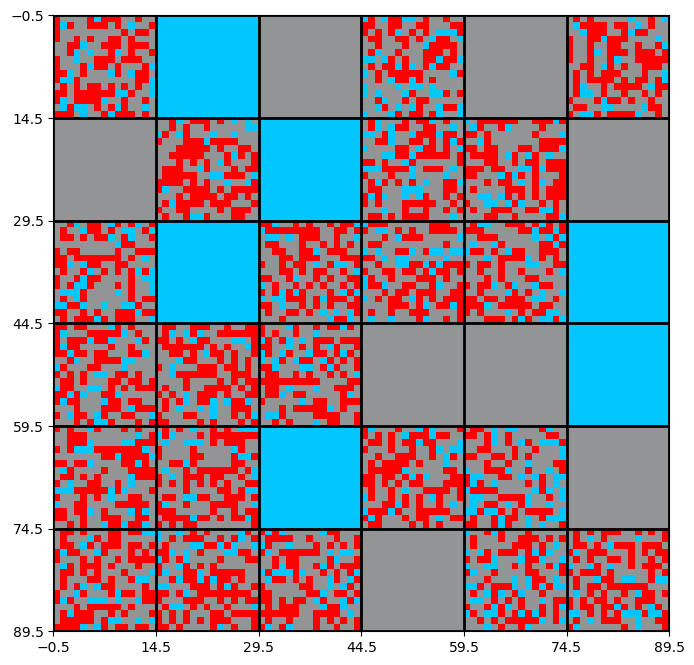

In [24]:
n = 15
q = 6
Ti = 1
Tf = 0
agent_density = 0.5
resident_relative_density = 0.5

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 1000000
passo = steps/5
freezing_time = 1/2
Ts = np.linspace(Ti, Tf, int(freezing_time*steps))

for a in range(steps):
    if a < len(Ts):
        T = Ts[a]
    else:
        T = Tf
        
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        print(T)
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

# IGNORAR

#### T = 0.01

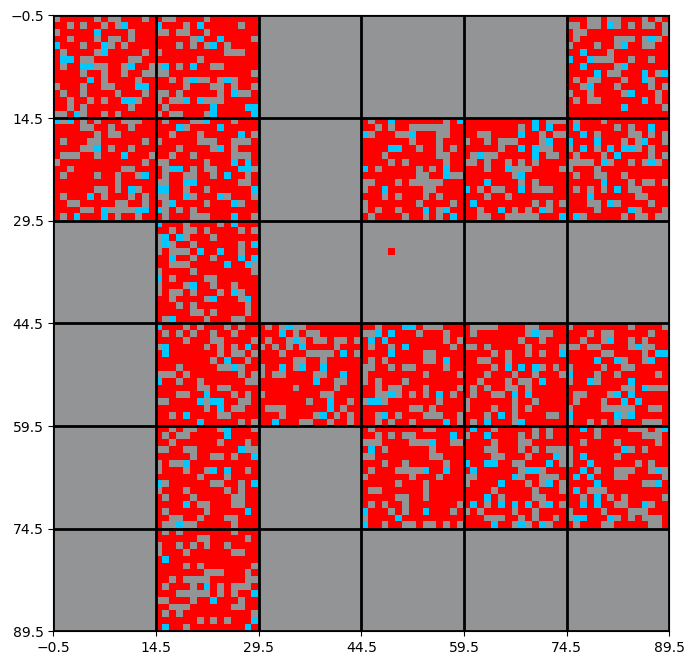

In [66]:
n = 15
q = 6
T = 0.01
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 0.1

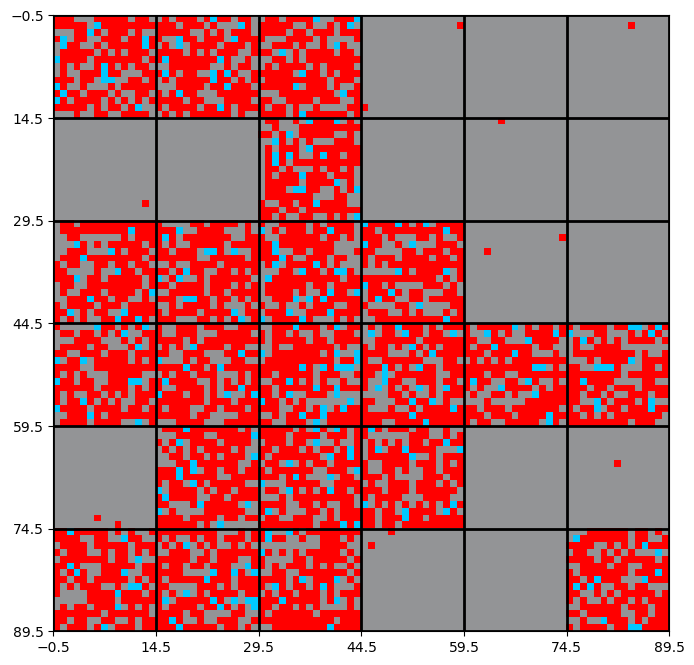

In [67]:
n = 15
q = 6
T = 0.1
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 0.2

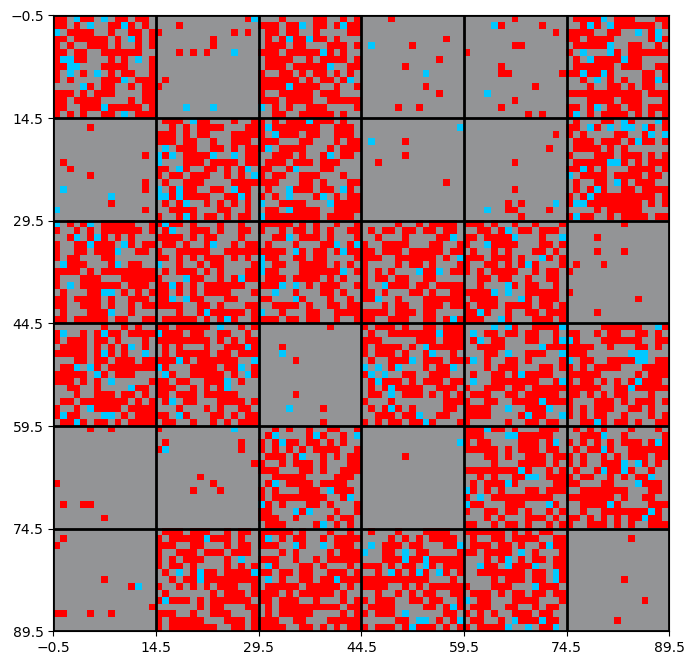

In [68]:
n = 15
q = 6
T = 0.2
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 0.4

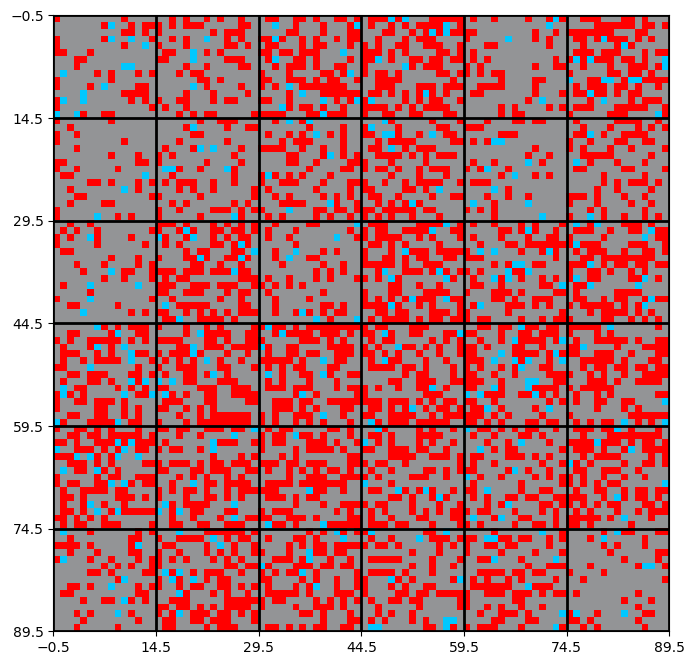

In [ ]:
n = 15
q = 6
T = 0.4
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 0.6

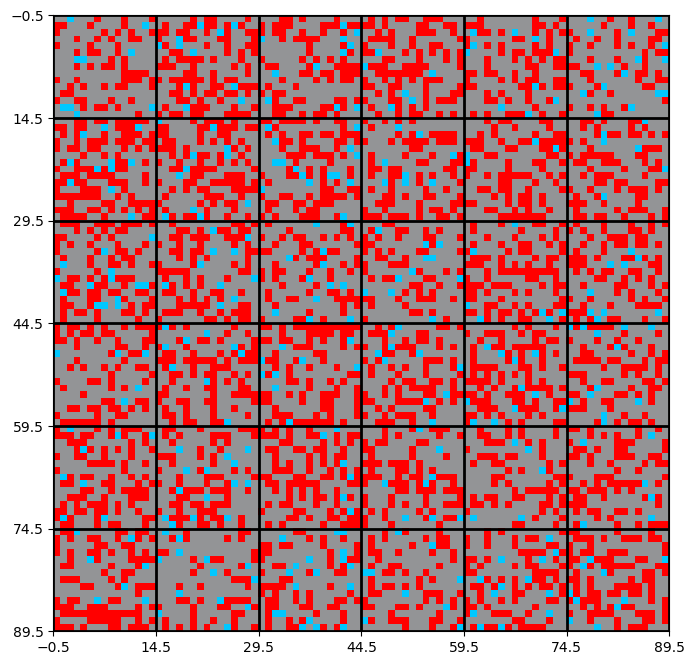

In [ ]:
n = 15
q = 6
T = 0.6
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 0.8

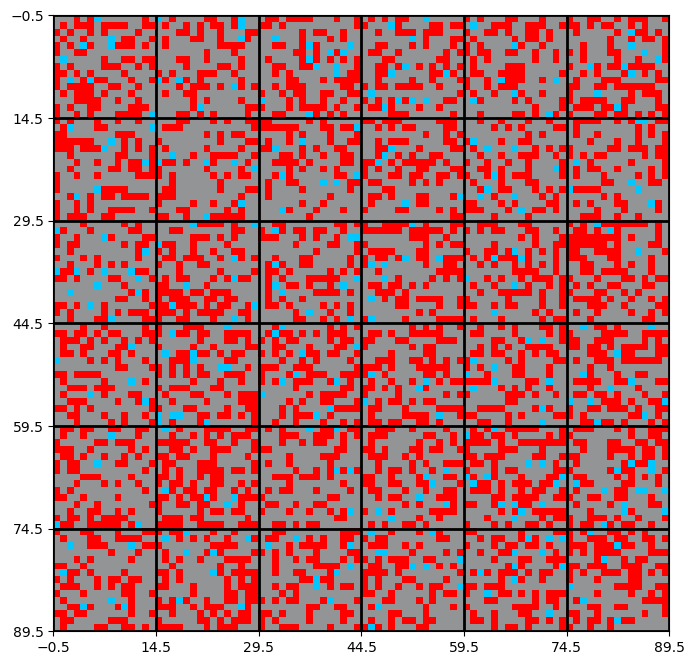

In [ ]:
n = 15
q = 6
T = 0.8
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

#### T = 1

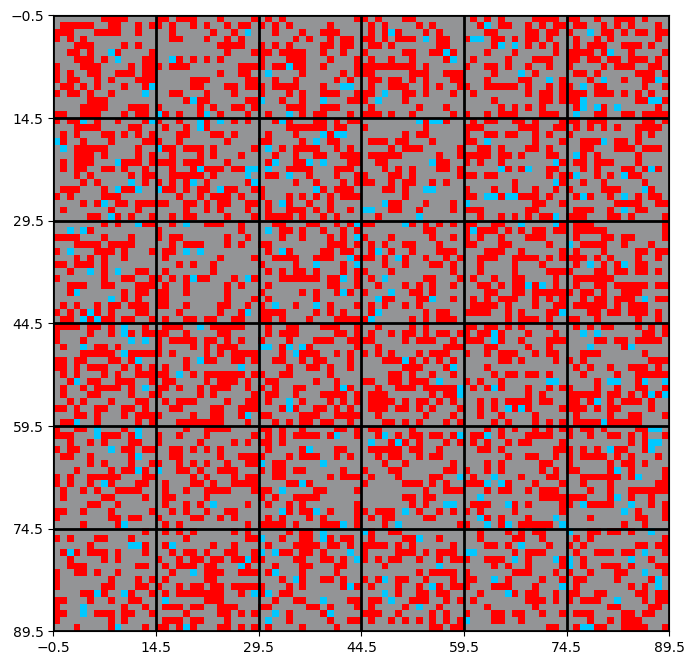

In [ ]:
n = 15
q = 6
T = 1
agent_density = 0.4
resident_relative_density = 0.9

city, vacancy_array, agent_array, density_array, residents, merchants = create_city(n, q, agent_density, resident_relative_density)

print(residents/(residents+merchants),merchants/(residents+merchants), (residents+merchants)/(n*n*q*q))
time.sleep(1)

steps = 100000
passo = 2000
for a in range(steps):
    city, vacancy_array, agent_array, density_array = simulation_step(n, T, city, vacancy_array, agent_array, density_array)
    
    if(a%passo == 0):
        plot_grid(city, n)
        print(str(a/steps * 100) + '%')
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.1

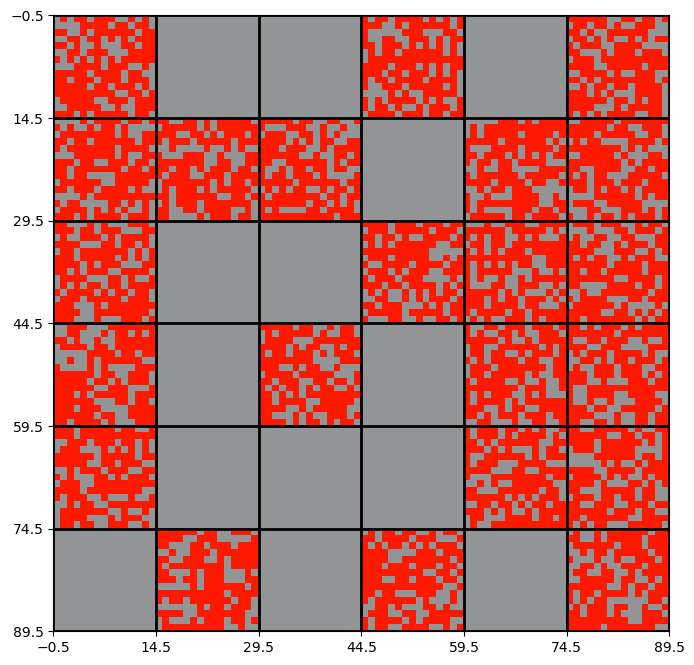

In [50]:
n = 15
q = 6
T = 0
alpha = 0.1
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.2

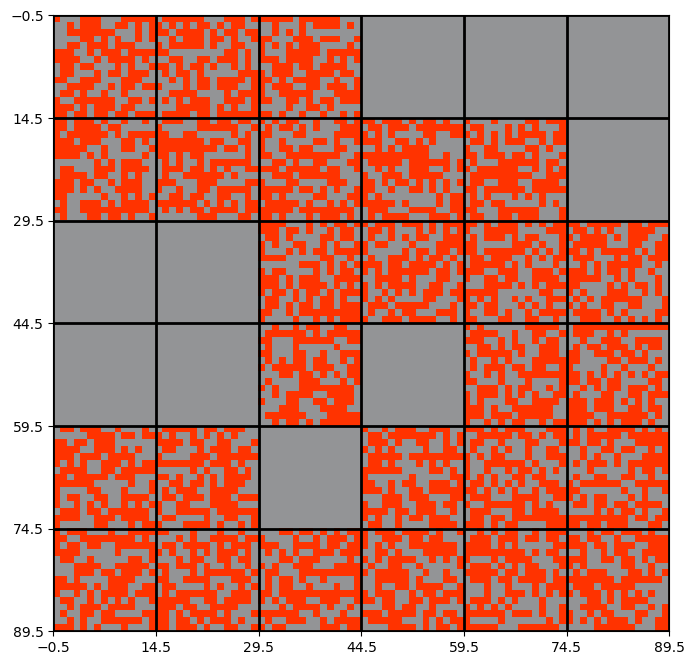

In [51]:
n = 15
q = 6
T = 0
alpha = 0.2
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.3

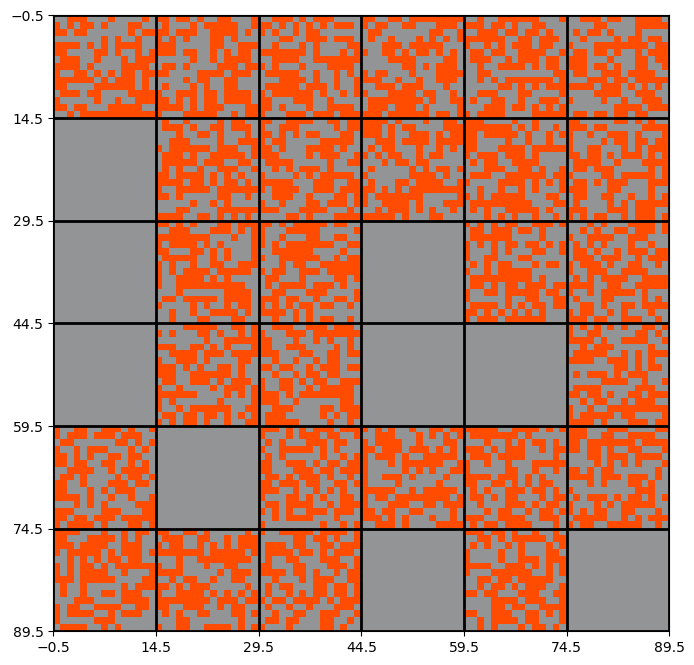

In [52]:
n = 15
q = 6
T = 0
alpha = 0.3
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.4

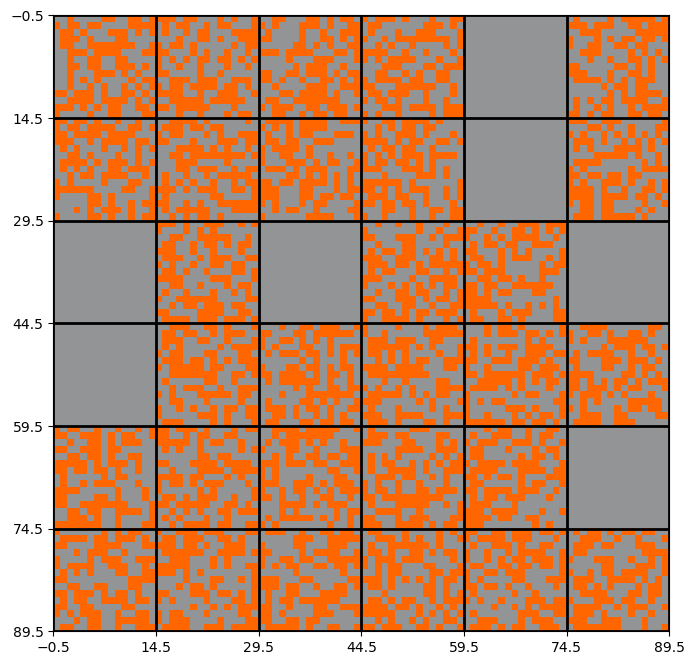

In [53]:
n = 15
q = 6
T = 0
alpha = 0.4
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.5

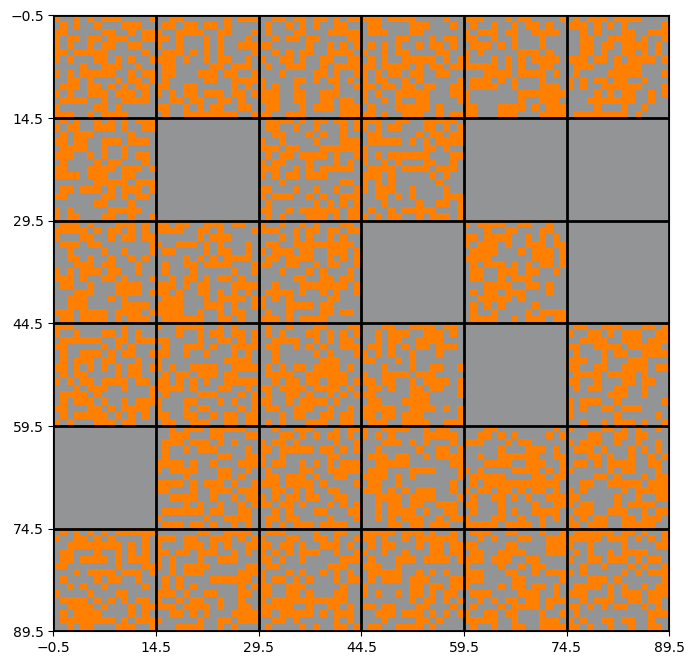

In [54]:
n = 15
q = 6
T = 0
alpha = 0.5
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.6

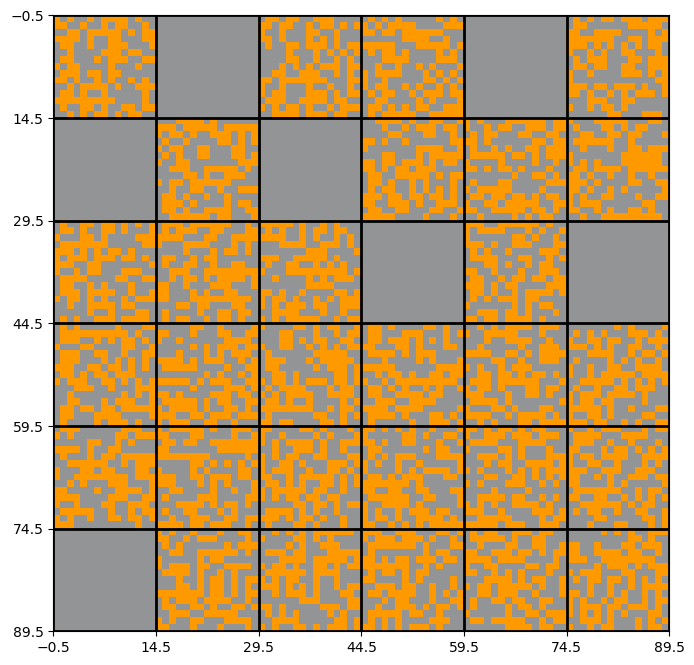

In [55]:
n = 15
q = 6
T = 0
alpha = 0.6
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.7

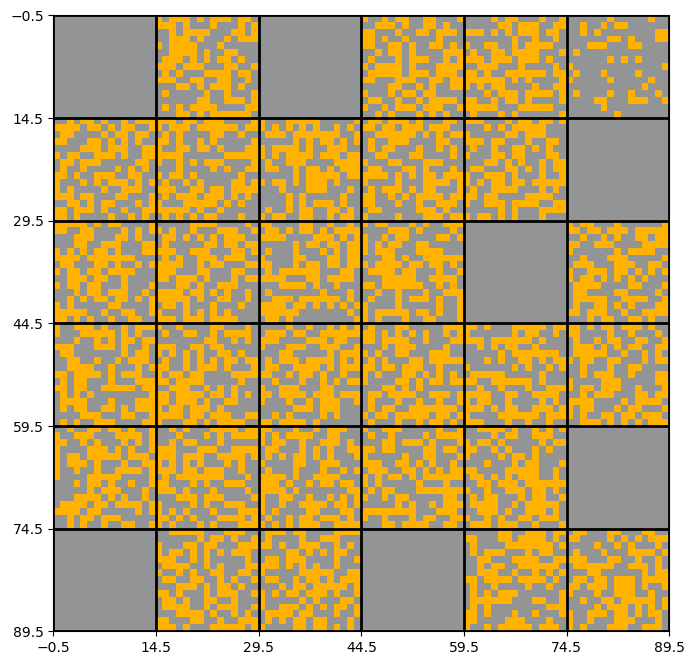

In [56]:
n = 15
q = 6
T = 0
alpha = 0.7
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.8

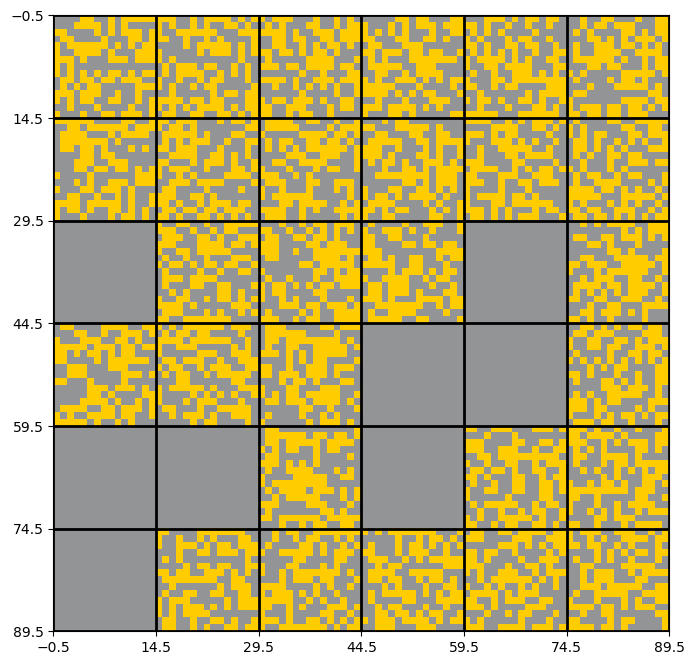

In [57]:
n = 15
q = 6
T = 0
alpha = 0.8
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)

##### Alpha = 0.9

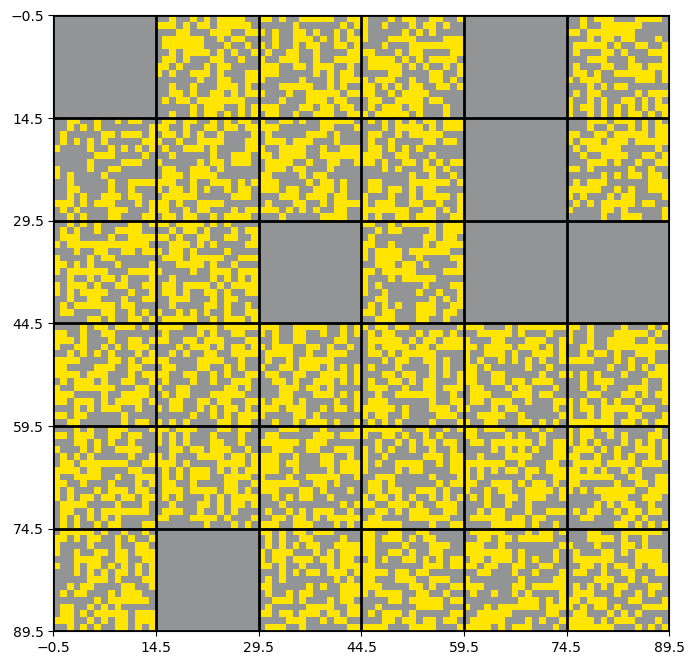

In [10]:
n = 15
q = 6
T = 0
alpha = 0.9
agent_density = 0.4

city, vacancy_array, agent_array, density_array = create_city(n, q, agent_density)

city_utility = detect_city_utility(n, density_array)

steps = 100000
passo = 500
for a in range(steps):
    city, vacancy_array, agent_array, density_array, city_utility = simulation_step(n, T, alpha, city, vacancy_array, agent_array, density_array, city_utility)
    
    if(a%passo == 0):
        print(str(a/steps * 100) + '%')
        plot_grid(city, n)
        time.sleep(0.1)
        display.clear_output(wait=True)
        
plot_grid(city, n)